In [1]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from scipy.stats import poisson, norm, chi2
from scipy.special import gamma, factorial
from scipy.optimize import fsolve, root, brentq

# from numba import jit

<h3>Step 1: Build likelihood function:</h3>
The simplest Likelihood function (without considering nuisance parameters) is given by:

$$ L(\mu) = \frac{(\mu s + b)^{n}}{n!}e^{-(\mu s + b)} $$


In [2]:
# define factorial
# likelihood function
def likelihood(n : list, nb, ns, mu:list) -> list:
    '''
    Obtain the Likelihood for a specific set of data
    n : # observed of events (numpy array)
    nb : # of background events
    ns : # of signal events
    mu : strength parameter (numpy array)
    '''        
    
    if len(n) != len(mu):
        print('error msg')
    
    ntot = nb + mu*ns
    prob = poisson.pmf(n, ntot)
#     prob = (ntot**n)*(np.exp(-ntot)/factorial(n))
    
    return prob

In [3]:
def muHat(n, nb, ns):
    
    muHat = (n - nb)/ns
    
    return muHat

In [4]:
def profLikelihood(n, nb, ns, mu):
    
    L = likelihood(n, nb, ns, mu)
    Lmax = likelihood(n, nb, ns, muHat(n, nb, ns))
    return L/Lmax

In [5]:
#find a way to select only positive muHat
def qtest(n, nb, ns, allowNegativeMu=False):
    
    mu = np.array([1.]*len(n))
    if not allowNegativeMu:
        q = np.where(muHat(n, nb, ns) > 0,
                     -2.*np.log(profLikelihood(n, nb, ns, mu)),
                     0.)
    else:

        q = -2.*np.log(profLikelihood(n, nb, ns, mu))
    
    
    return q

In [82]:
# Set known values
ns = 24.933117
nb = 58.836
mu = 1.
nobs = 60.
nsim = int(1e6)
nobs = 60.


# Generate samples under null hypothesis
def genData(mu, nb, ns, nsim):
    ngen = np.random.poisson(lam=mu*ns+nb, size=nsim) 
    return ngen


pseudoN = genData(mu, nb, ns, nsim)

In [83]:
%%time
negativeMu = True
q0 = qtest(pseudoN, nb, ns, negativeMu)
negativeMu = False
q0B = qtest(pseudoN, nb, ns, negativeMu)

CPU times: user 313 ms, sys: 31.4 ms, total: 344 ms
Wall time: 341 ms


In [84]:
qobs = qtest(np.array([nobs]), nb, ns)
qvals = np.linspace(q0.min(), q0.max(), 100)

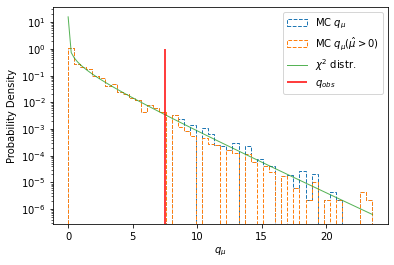

In [85]:
# Plot histogram
hist = plt.hist(q0, bins=50, density=True, linestyle='--', histtype='step', label=r'MC $q_{\mu}$')
histB = plt.hist(q0B, bins=50, density=True, linestyle='--', histtype='step', label=r'MC $q_{\mu} (\hat{\mu}>0)$')
plt.plot(qvals, chi2.pdf(qvals, df=1), linewidth=1, alpha=0.8, label=r'$\chi^{2}$ distr.')
plt.vlines(qobs, 0, 1, 'red', label=r'$q_{obs}$')

plt.legend()
plt.ylabel('Probability Density')
plt.xlabel(r'$q_{\mu}$')
plt.yscale('log')
# plt.ylim(1e-4,1)
plt.show()

In [86]:
# p-value from histogram
pval_mc = len(q0[q0>=qobs])/len(q0)

# p-value from chisquared distr.
pval_chi = 1 - chi2.cdf(qobs, 1)

print('p-value following MC method:', pval_mc)
print('p-value from chi squared distribution:', pval_chi)

p-value following MC method: 0.006478
p-value from chi squared distribution: [0.00619788]


In [87]:
# p-value from histogram
pval_mc = len(q0B[q0B>=qobs])/len(q0B)

# p-value from chisquared distr.
pval_chi = 1 - chi2.cdf(qobs, 1)

print('p-value following MC method (mu>0):', pval_mc)
print('p-value from chi squared distribution:', pval_chi)

p-value following MC method (mu>0): 0.004677
p-value from chi squared distribution: [0.00619788]


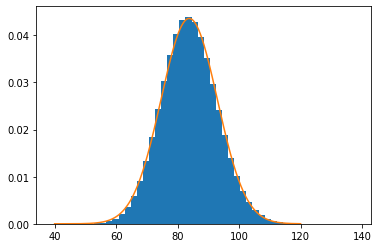

In [70]:
plt.hist(pseudoN,bins=50,density=True)
xvals = np.linspace(40,120,1000)
from scipy.stats import norm
plt.plot(xvals,norm.pdf(xvals,loc=(ns+nb),scale=np.sqrt(ns+nb)))
plt.show()

In [71]:
np.mean(pseudoN),np.std(pseudoN)

(83.76840291, 9.151730005736805)

In [72]:
nb+ns,np.sqrt(nb+ns)

(83.769117, 9.152547022550607)

Let us now test different values of s and b: